In [ ]:
## Importing libraries

!pip install librosa
!pip install tqdm
!pip install plotly
import os
import random
import sys
import glob
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import warnings
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
import plotly.offline as py

warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
py.init_notebook_mode(connected=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Audio_Speech_Actors_01-24.zip' .
!unzip -q Audio_Speech_Actors_01-24.zip

In [ ]:
import os
import glob

def metadata(basepath):
    df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'intensity', 'statement', 'repetition', 'emotion'])
    count = 0

    actor_folders = glob.glob(basepath)
    for actor_folder in actor_folders:
     if os.path.isdir(actor_folder):
        try:
            actor = int(os.path.basename(actor_folder).split('_')[-1])
        except ValueError:
            print("Invalid actor folder:", actor_folder)
            continue

        actor_files = glob.glob(actor_folder + '/*.wav')
        for file_path in actor_files:
            print("Actor folder:", actor_folder)  # Print the actor_folder for troubleshooting
            actor = int(os.path.basename(actor_folder).split('_')[-1])  # Extract the actor number correctly
            filename = os.path.basename(file_path).split('.')[0].split('-')
            if len(filename) == 7:
                src = int(filename[1])
                emotion = int(filename[2])

                gender = "female" if actor % 2 == 0 else "male"
                intensity = 0 if filename[3] == '01' else 1
                statement = 0 if filename[4] == '01' else 1
                repeat = 0 if filename[5] == '01' else 1

                df.loc[count] = [file_path, src, actor, gender, intensity, statement, repeat, emotion]
                count += 1


    labels = []
    y = []
    for i in range(len(df)):
        if df.emotion.iloc[i] == 1:
            label = "_neutral"
            y.append(1)
        elif df.emotion.iloc[i] == 2:
            label = "_calm"
            y.append(2)
        elif df.emotion.iloc[i] == 3:
            label = "_happy"
            y.append(3)
        elif df.emotion.iloc[i] == 4:
            label = "_sad"
            y.append(4)
        elif df.emotion.iloc[i] == 5:
            label = "_angry"
            y.append(5)
        elif df.emotion.iloc[i] == 6:
            label = "_fearful"
            y.append(6)
        elif df.emotion.iloc[i] == 7:
            label = "_disgust"
            y.append(7)
        elif df.emotion.iloc[i] == 8:
            label = "_surprised"
            y.append(8)
        else:
            label = "_none"

        # Add gender to the label
        labels.append(label)

    df['label'] = labels

    return df

basepath = '/content/Actor_*'
df = metadata(basepath)


Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor fo

In [ ]:
y = df.emotion.values.tolist()

In [ ]:
import random

class Spectrograms():
    def __init__(self, df, datasettype, outputpath, sample=False, augmentation=False, mel=True, mfcc=False, spectral=False, mfccbanks=20, n_mels=128):
        self.df = df
        self.augmentation = augmentation
        self.mel = mel
        self.mfcc = mfcc
        self.spectral = spectral
        self.mfccbanks = mfccbanks
        self.n_mels = n_mels
        self.outputpath = outputpath
        self.datasettype = datasettype
        self.sample = sample

    def get_spectrograms(self):
        if self.sample:
            x, sample_rate = librosa.load(self.df.index[0])
            self.generate(x, sample_rate, '', 0, snr=None)

        else:
            for file in tqdm(range(self.df.shape[0])):
                emotion = df.iloc[file, df.columns.get_loc('label')]
                path = self.outputpath+self.datasettype+"/"+str(emotion)+"/"

                if not os.path.isdir(path):
                    os.makedirs(path)

                ## Reading signal from .wav file
                x, sample_rate = librosa.load(self.df.index[file])
                emo = df.iloc[file, df.columns.get_loc('emotion')]
                self.generate(x, sample_rate, path, file, emo)


    def generate(self, x, sample_rate, path, count, emo, snr=0):
        if self.mel:
            mel_features = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_mels=self.n_mels)

            log_mel_features = librosa.power_to_db(mel_features, ref=np.max)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(log_mel_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:

                plt.close()

            if snr is not None:
                # Calculate noise power based on desired SNR
                signal_power = np.mean(x**2)
                noise_power = signal_power / (10**(snr/10))

                # Generate white noise with the calculated power
                noise = np.random.normal(0, np.sqrt(noise_power), len(x))
                x_with_noise = x + noise

                # Generate spectrogram for the noisy signal
                mel_features_with_noise = librosa.feature.melspectrogram(y=x_with_noise, sr=sample_rate, n_mels=self.n_mels)
                log_mel_features_with_noise = librosa.power_to_db(mel_features_with_noise, ref=np.max)

                # Display or save the spectrogram with noise
                fig_with_noise = plt.figure(figsize=(12,4))
                ax_with_noise = plt.Axes(fig_with_noise, [0., 0., 1., 1.])
                ax_with_noise.set_axis_off()
                fig_with_noise.add_axes(ax_with_noise)
                librosa.display.specshow(log_mel_features_with_noise, sr=sample_rate, x_axis='time', y_axis='mel')
                if self.sample:
                    plt.show()
                else:
                    plt.savefig(path+str(emo)+"-"+str(count)+"_with_noise.jpg")
                plt.close(fig_with_noise)

        if self.mfcc:
            mfcc_features = librosa.feature.mfcc(x, sr=sample_rate, n_mfcc=self.mfccbanks)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(mfcc_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"mfccspectrogram_"+str(count)+".jpg")
                plt.close()

        if self.spectral:
            spectral_features = librosa.feature.spectral_contrast(x, sr=sample_rate)
            fig = plt.figure(figsize=(12,4))
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            librosa.display.specshow(spectral_features, sr=sample_rate, x_axis='time', y_axis='mel')
            if self.sample:
                plt.show()
            else:
                plt.savefig(path+"spectralspectrogram_"+str(count)+".jpg")
                plt.close()


In [ ]:
df_new = metadata('/content/Actor_*')


Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor folder: /content/Actor_18
Actor fo

In [ ]:
df_new.index = df_new.path
df_new = df_new.drop("path", axis=1)

In [ ]:
spectrograms = Spectrograms(df_new, 'images_new', '/content/spectrograms', sample=False)
spectrograms.get_spectrograms()

100%|██████████| 1440/1440 [04:52<00:00,  4.93it/s]


In [ ]:
!pip install opencv-python
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
categories = os.listdir("/content/spectrogramsimages_new")
len(categories)

8

In [ ]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_array = Image.fromarray(img, 'RGB')

            # Resize image to 224 x 224 to match VGGNet's input image resolution
            resized_img = img_array.resize((224, 224))

            img_lst.append(np.array(resized_img))

            labels.append(index)
    return img_lst, labels

fpath = "/content/spectrogramsimages_new"
images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))



No. of images loaded =  1440 
No. of labels loaded =  1440
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1440, 224, 224, 3) 
Labels shape =  (1440,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
#1-step in data shuffling
random_seed=42
#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1437 1438 1439]

'n' values after shuffling =  [ 168  605  548 ... 1294  860 1126]


In [ ]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1440, 224, 224, 3) 
Labels shape after shuffling =  (1440,)


In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1440, 224, 224, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1152, 224, 224, 3)
y_train shape =  (1152,)

x_test shape =  (288, 224, 224, 3)
y_test shape =  (288,)


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import numpy as np

def dense_block(x, num_layers, growth_rate, dropout_rate, weight_decay):
    for _ in range(num_layers):
        # 3x3 convolution
        x = Conv2D(growth_rate, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        if dropout_rate:
            x = Dropout(dropout_rate)(x)
    return x

def DenseNet(input_shape=(224, 224, 3), num_classes=20, num_dense_blocks=3,
             num_layers_per_block=4, growth_rate=32, compression_factor=0.5,
             dropout_rate=0.2, weight_decay=1e-4):

    inputs = Input(shape=input_shape)
    x = inputs

    # Initial Convolution
    x = Conv2D(growth_rate * 2, (3, 3), padding='same', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    # Dense blocks with transition layers
    for block in range(num_dense_blocks):
        # Dense block
        x = dense_block(x, num_layers_per_block, growth_rate, dropout_rate, weight_decay)
        # Transition layer (compress features)
        x = Conv2D(int(np.floor(x.shape[-1] * compression_factor)), (1, 1), padding='same',
                   strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Final part (global average pooling + fully connected)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(weight_decay))(x)

    # Create the model
    model = Model(inputs, x, name='densenet')
    return model

# Define the model
input_shape = (224, 224, 3)
num_classes = 20
model = DenseNet(input_shape=input_shape, num_classes=num_classes)

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                        

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator without any augmentation options
datagen = ImageDataGenerator(rescale=1./255)

# Set up the flow of data using the ImageDataGenerator
batch_size = 32
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

# Train your model using the flow of data from the generator
model.fit(train_generator, epochs=100)

Epoch 1/100
36/36 [==============================] - 8s 230ms/step - loss: 0.0762 - accuracy: 0.9722
Epoch 2/100
36/36 [==============================] - 8s 232ms/step - loss: 0.0477 - accuracy: 0.9835
Epoch 3/100
36/36 [==============================] - 9s 234ms/step - loss: 0.0782 - accuracy: 0.9757
Epoch 4/100
36/36 [==============================] - 9s 239ms/step - loss: 0.0425 - accuracy: 0.9861
Epoch 5/100
36/36 [==============================] - 8s 235ms/step - loss: 0.0522 - accuracy: 0.9818
Epoch 6/100
36/36 [==============================] - 8s 231ms/step - loss: 0.0463 - accuracy: 0.9852
Epoch 7/100
36/36 [==============================] - 8s 232ms/step - loss: 0.0711 - accuracy: 0.9748
Epoch 8/100
36/36 [==============================] - 8s 231ms/step - loss: 0.0278 - accuracy: 0.9887
Epoch 9/100
36/36 [==============================] - 8s 231ms/step - loss: 0.0257 - accuracy: 0.9913
Epoch 10/100
36/36 [==============================] - 8s 233ms/step - loss: 0.0304 - accura

In [ ]:
%%time
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
36/36 [==============================] - 34s 222ms/step - loss: 3.4392 - accuracy: 0.1884
Epoch 2/100
36/36 [==============================] - 8s 223ms/step - loss: 2.7657 - accuracy: 0.2422
Epoch 3/100
36/36 [==============================] - 8s 227ms/step - loss: 2.4003 - accuracy: 0.2856
Epoch 4/100
36/36 [==============================] - 8s 227ms/step - loss: 2.2291 - accuracy: 0.3021
Epoch 5/100
36/36 [==============================] - 8s 229ms/step - loss: 2.0241 - accuracy: 0.3411
Epoch 6/100
36/36 [==============================] - 8s 231ms/step - loss: 1.9872 - accuracy: 0.3255
Epoch 7/100
36/36 [==============================] - 8s 233ms/step - loss: 1.8459 - accuracy: 0.3889
Epoch 8/100
36/36 [==============================] - 8s 233ms/step - loss: 1.7243 - accuracy: 0.4184
Epoch 9/100
36/36 [==============================] - 8s 228ms/step - loss: 1.6185 - accuracy: 0.4505
Epoch 10/100
36/36 [==============================] - 8s 229ms/step - loss: 1.5851 - accur

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)


9/9 [==============================] - 1s 71ms/step


In [ ]:
predictions
y_test
new_Ytest = y_test.astype(int)
new_Ytest

array([1, 1, 0, 1, 0, 5, 3, 1, 1, 6, 7, 4, 2, 3, 3, 5, 2, 3, 7, 4, 3, 7,
       0, 1, 4, 7, 7, 5, 3, 2, 0, 4, 4, 2, 1, 0, 1, 3, 1, 1, 0, 5, 2, 3,
       2, 0, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 5, 2, 0, 1, 6, 2, 2, 4, 7,
       7, 4, 6, 4, 7, 0, 6, 6, 7, 3, 0, 6, 0, 1, 3, 3, 7, 7, 3, 3, 5, 4,
       7, 2, 0, 0, 0, 2, 6, 5, 3, 2, 4, 7, 0, 1, 1, 1, 6, 5, 0, 4, 7, 0,
       5, 0, 5, 0, 1, 6, 4, 1, 0, 6, 1, 1, 7, 1, 3, 7, 2, 2, 6, 6, 1, 2,
       2, 2, 2, 5, 4, 0, 1, 6, 0, 7, 1, 1, 5, 5, 3, 7, 6, 6, 2, 2, 6, 5,
       6, 5, 7, 2, 3, 1, 3, 1, 6, 5, 3, 1, 0, 4, 7, 5, 0, 6, 4, 2, 2, 2,
       5, 2, 6, 1, 1, 6, 5, 7, 7, 2, 1, 6, 7, 2, 7, 0, 2, 1, 5, 3, 4, 5,
       5, 7, 3, 6, 0, 2, 7, 0, 7, 3, 1, 4, 0, 6, 2, 4, 4, 1, 4, 3, 3, 5,
       1, 3, 7, 3, 3, 2, 3, 3, 2, 5, 1, 5, 1, 3, 0, 2, 6, 0, 3, 4, 3, 3,
       1, 5, 1, 7, 2, 0, 7, 0, 0, 3, 0, 7, 2, 4, 0, 0, 6, 5, 3, 5, 6, 2,
       6, 6, 0, 7, 3, 7, 0, 7, 5, 6, 3, 3, 7, 6, 7, 4, 6, 4, 1, 0, 1, 0,
       1, 6])

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(new_Ytest, predicted_classes)
print(report)



              precision    recall  f1-score   support

           0       0.14      1.00      0.25        41
           1       1.00      0.02      0.05        43
           2       1.00      0.05      0.10        38
           3       0.00      0.00      0.00        40
           4       0.50      0.04      0.08        24
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        35
           7       0.00      0.00      0.00        37

    accuracy                           0.16       288
   macro avg       0.33      0.14      0.06       288
weighted avg       0.34      0.16      0.06       288



In [ ]:
from sklearn.metrics import confusion_matrix

new_Ytest = new_Ytest.astype(int)
matrix = confusion_matrix(new_Ytest, predicted_classes)
print(matrix)


[[41  0  0  0  0  0  0  0]
 [42  1  0  0  0  0  0  0]
 [36  0  2  0  0  0  0  0]
 [40  0  0  0  0  0  0  0]
 [23  0  0  0  1  0  0  0]
 [30  0  0  0  0  0  0  0]
 [34  0  0  0  1  0  0  0]
 [37  0  0  0  0  0  0  0]]


9/9 [==============================] - 1s 69ms/step


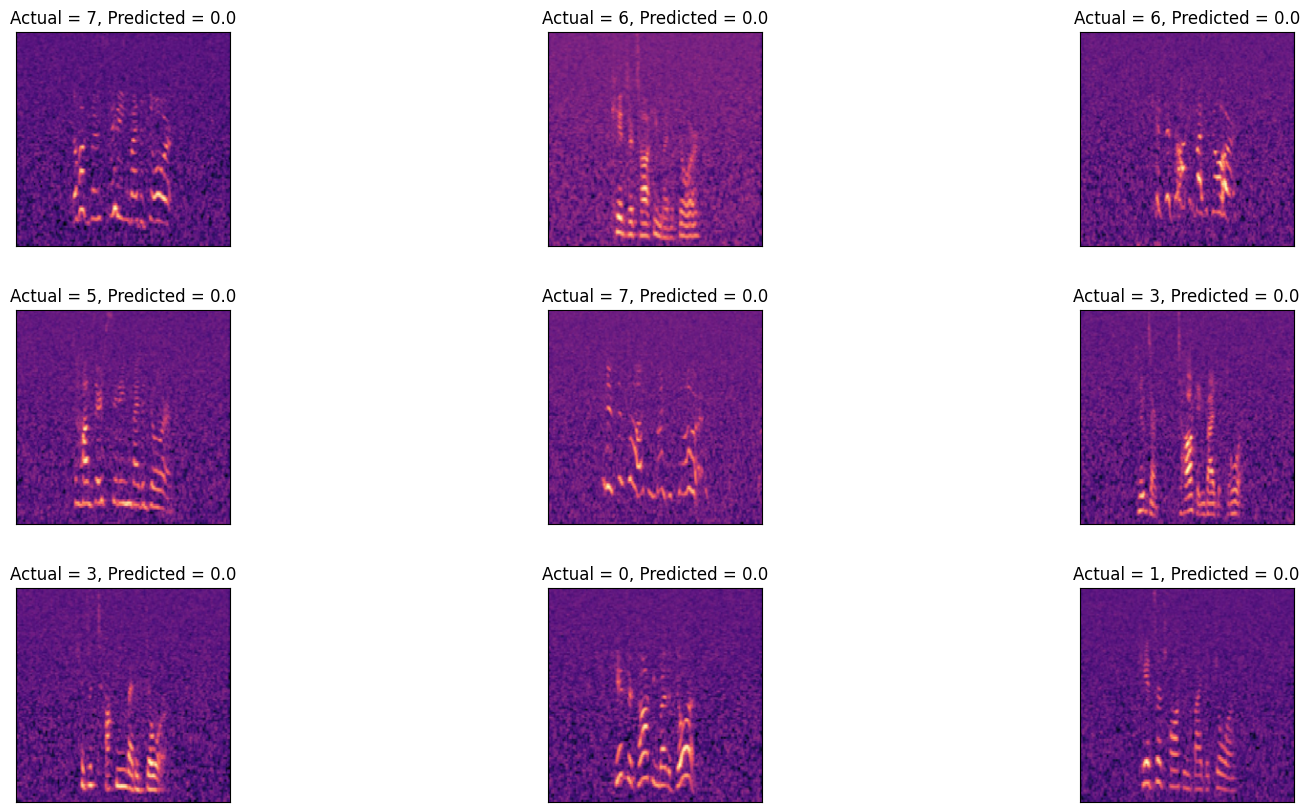

In [ ]:
pred = model.predict(x_test)
plt.figure(1 , figsize = (19 , 10))
n = 0

for i in range(9):
    n += 1
    r = np.random.randint( 0, x_test.shape[0], 1)

    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [ ]:

IMG_SHAPE = images.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 32)                4816928   
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       4967424   
                                                                 
Total params: 9,784,352
Trainable params: 9,784,352
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = autoencoder.fit(x=x_train, y=x_train, epochs=20,
                validation_data=[x_test, x_test])

Epoch 1/20
36/36 [==============================] - 3s 48ms/step - loss: 0.2087 - val_loss: 0.0120
Epoch 2/20
36/36 [==============================] - 1s 30ms/step - loss: 0.0076 - val_loss: 0.0057
Epoch 3/20
36/36 [==============================] - 1s 33ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/20
36/36 [==============================] - 1s 40ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 5/20
36/36 [==============================] - 1s 41ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 6/20
36/36 [==============================] - 1s 35ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 7/20
36/36 [==============================] - 1s 29ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 8/20
36/36 [==============================] - 1s 31ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/20
36/36 [==============================] - 1s 29ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/20
36/36 [==============================] - 1s 33ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 11/

45/45 [==============================] - 1s 12ms/step


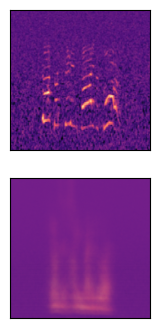

Accuracy= 0.9554477967321873 



In [ ]:
decoded_imgs = autoencoder.predict(images)

n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')

45/45 [==============================] - 1s 15ms/step


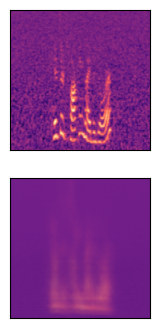

Accuracy= 0.9554477967321873 



In [ ]:
decoded_imgs = autoencoder.predict(images)
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(images[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Accuracy=",1-np.mean(abs(images-decoded_imgs)),'\n')


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(decoded_imgs, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",X_train.shape)
print("y_train shape = ",Y_train.shape)
print("\nx_test shape = ",X_test.shape)
print("y_test shape = ",Y_test.shape)

x_train shape =  (1152, 224, 224, 3)
y_train shape =  (1152,)

x_test shape =  (288, 224, 224, 3)
y_test shape =  (288,)


In [ ]:
%%time
model.fit(X_train, Y_train, epochs=300, batch_size=32)

Epoch 1/300
36/36 [==============================] - 8s 226ms/step - loss: 3.6164 - accuracy: 0.1424
Epoch 2/300
36/36 [==============================] - 8s 232ms/step - loss: 2.3579 - accuracy: 0.1345
Epoch 3/300
36/36 [==============================] - 8s 231ms/step - loss: 2.2547 - accuracy: 0.1771
Epoch 4/300
36/36 [==============================] - 8s 234ms/step - loss: 2.3026 - accuracy: 0.1415
Epoch 5/300
36/36 [==============================] - 8s 230ms/step - loss: 2.1857 - accuracy: 0.1936
Epoch 6/300
36/36 [==============================] - 8s 227ms/step - loss: 2.1340 - accuracy: 0.2214
Epoch 7/300
36/36 [==============================] - 8s 227ms/step - loss: 2.0881 - accuracy: 0.2266
Epoch 8/300
36/36 [==============================] - 8s 225ms/step - loss: 2.0799 - accuracy: 0.2257
Epoch 9/300
36/36 [==============================] - 8s 228ms/step - loss: 2.0576 - accuracy: 0.2500
Epoch 10/300
36/36 [==============================] - 8s 225ms/step - loss: 2.0225 - accura

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 829.119873046875
Test accuracy: 0.0


In [ ]:
predictions_new = np.argmax(model.predict(X_test), axis=-1)
predictions_new
y_test
new_Ytest_new = y_test.astype(int)
new_Ytest_new

9/9 [==============================] - 1s 63ms/step


array([1, 1, 0, 1, 0, 5, 3, 1, 1, 6, 7, 4, 2, 3, 3, 5, 2, 3, 7, 4, 3, 7,
       0, 1, 4, 7, 7, 5, 3, 2, 0, 4, 4, 2, 1, 0, 1, 3, 1, 1, 0, 5, 2, 3,
       2, 0, 0, 3, 6, 2, 3, 5, 1, 7, 1, 2, 6, 5, 2, 0, 1, 6, 2, 2, 4, 7,
       7, 4, 6, 4, 7, 0, 6, 6, 7, 3, 0, 6, 0, 1, 3, 3, 7, 7, 3, 3, 5, 4,
       7, 2, 0, 0, 0, 2, 6, 5, 3, 2, 4, 7, 0, 1, 1, 1, 6, 5, 0, 4, 7, 0,
       5, 0, 5, 0, 1, 6, 4, 1, 0, 6, 1, 1, 7, 1, 3, 7, 2, 2, 6, 6, 1, 2,
       2, 2, 2, 5, 4, 0, 1, 6, 0, 7, 1, 1, 5, 5, 3, 7, 6, 6, 2, 2, 6, 5,
       6, 5, 7, 2, 3, 1, 3, 1, 6, 5, 3, 1, 0, 4, 7, 5, 0, 6, 4, 2, 2, 2,
       5, 2, 6, 1, 1, 6, 5, 7, 7, 2, 1, 6, 7, 2, 7, 0, 2, 1, 5, 3, 4, 5,
       5, 7, 3, 6, 0, 2, 7, 0, 7, 3, 1, 4, 0, 6, 2, 4, 4, 1, 4, 3, 3, 5,
       1, 3, 7, 3, 3, 2, 3, 3, 2, 5, 1, 5, 1, 3, 0, 2, 6, 0, 3, 4, 3, 3,
       1, 5, 1, 7, 2, 0, 7, 0, 0, 3, 0, 7, 2, 4, 0, 0, 6, 5, 3, 5, 6, 2,
       6, 6, 0, 7, 3, 7, 0, 7, 5, 6, 3, 3, 7, 6, 7, 4, 6, 4, 1, 0, 1, 0,
       1, 6])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest_new, predictions_new)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      41.0
           1       0.00      0.00      0.00      43.0
           2       0.00      0.00      0.00      38.0
           3       0.00      0.00      0.00      40.0
           4       0.00      0.00      0.00      24.0
           5       0.00      0.00      0.00      30.0
           6       0.00      0.00      0.00      35.0
           7       0.00      0.00      0.00      37.0
          17       0.00      0.00      0.00       0.0

    accuracy                           0.00     288.0
   macro avg       0.00      0.00      0.00     288.0
weighted avg       0.00      0.00      0.00     288.0



In [ ]:
from sklearn.metrics import classification_report, matthews_corrcoef

report = classification_report(new_Ytest_new, predictions_new)
print(report)

# Calculate MCC for each emotion
emotions = [0, 1, 2, 3, 4, 5, 6, 7]  # Replace with your actual emotion labels
mcc_scores = {}
for emotion in emotions:
    emotion_indices = (new_Ytest_new == emotion)
    emotion_predictions = predictions_new[emotion_indices]
    emotion_labels = new_Ytest_new[emotion_indices]
    mcc_scores[emotion] = matthews_corrcoef(emotion_labels, emotion_predictions)

# Print MCC scores for each emotion
for emotion, mcc in mcc_scores.items():
    print(f"MCC for emotion {emotion}: {mcc}")



              precision    recall  f1-score   support

           0       0.00      0.00      0.00      41.0
           1       0.00      0.00      0.00      43.0
           2       0.00      0.00      0.00      38.0
           3       0.00      0.00      0.00      40.0
           4       0.00      0.00      0.00      24.0
           5       0.00      0.00      0.00      30.0
           6       0.00      0.00      0.00      35.0
           7       0.00      0.00      0.00      37.0
          17       0.00      0.00      0.00       0.0

    accuracy                           0.00     288.0
   macro avg       0.00      0.00      0.00     288.0
weighted avg       0.00      0.00      0.00     288.0

MCC for emotion 0: 0.0
MCC for emotion 1: 0.0
MCC for emotion 2: 0.0
MCC for emotion 3: 0.0
MCC for emotion 4: 0.0
MCC for emotion 5: 0.0
MCC for emotion 6: 0.0
MCC for emotion 7: 0.0


In [ ]:

import matplotlib.pyplot as plt

# Train the model and obtain the history object
history = model.fit(x_train, y_train, epochs=300, validation_data=(x_test, y_test))

# Plot the accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


Epoch 1/300
36/36 [==============================] - 10s 266ms/step - loss: 0.2084 - accuracy: 0.9436 - val_loss: 5.7684 - val_accuracy: 0.1667
Epoch 2/300
36/36 [==============================] - 9s 258ms/step - loss: 0.1284 - accuracy: 0.9592 - val_loss: 3.8657 - val_accuracy: 0.4062
Epoch 3/300
36/36 [==============================] - 9s 259ms/step - loss: 0.0638 - accuracy: 0.9774 - val_loss: 3.2417 - val_accuracy: 0.4965
Epoch 4/300
36/36 [==============================] - 9s 256ms/step - loss: 0.0279 - accuracy: 0.9931 - val_loss: 1.7428 - val_accuracy: 0.6215
Epoch 5/300
36/36 [==============================] - 9s 254ms/step - loss: 0.0268 - accuracy: 0.9931 - val_loss: 1.4895 - val_accuracy: 0.6840
Epoch 6/300
36/36 [==============================] - 9s 251ms/step - loss: 0.0194 - accuracy: 0.9948 - val_loss: 1.6127 - val_accuracy: 0.6875
Epoch 7/300
36/36 [==============================] - 9s 251ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 2.1547 - val_accuracy: 0.604